In [78]:
import ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from scipy import signal
# import neurokit2 as nk
import random
# %matplotlib inline 
import pyhrv
import ipynb

from ipynb.fs.full.ECG_features import get_ecgfeatures
from ipynb.fs.full.EDA import get_edaindex, get_edafeatures

In [79]:
class read_data_of_one_subject:
            """Read data from WESAD dataset"""
            def __init__(self, path, subject):
                self.keys = ['label', 'subject', 'signal']
                self.signal_keys = ['wrist', 'chest']
                self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
                self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
                #os.chdir(path)
                #os.chdir(subject)
                with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
                    data = pickle.load(file, encoding='latin1')
                self.data = data

            def get_labels(self):
                return self.data[self.keys[0]]

            def get_wrist_data(self):
                """"""
                #label = self.data[self.keys[0]]
                assert subject == self.data[self.keys[1]]
                signal = self.data[self.keys[2]]
                wrist_data = signal[self.signal_keys[0]]
                #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
                #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
                return wrist_data

            def get_chest_data(self):
                """"""
                signal = self.data[self.keys[2]]
                chest_data = signal[self.signal_keys[1]]
                return chest_data

In [80]:
# Set up empty dataframes for the features
ecgfeatures = pd.DataFrame(None, columns= ['feat_rmssd', 'feat_nnhr', 
                                    'feat_sdsd', 'feat_pnn50', 'feat_pnn20', 'peak vlf', 'peak lf','peak hf', 'norm power lf', 
                                    'norm power hf', 'power ratio', 'total power'])
edafeatures = None

fs = 700
y = []
data_set_path= "C:/Users/riche/Downloads/WESAD/WESAD/" # Folder path

for i in range(16): # 15 subject
    subject = 'S'+str(i+2) # Cycle through S2 to S17
    print(subject)
    if subject != 'S12': # Skip S12, because it does nog exist
        for label in range(1,5): # for every state of stress

            # Object instantiation
            obj_data = {}

            # Accessing class attributes and method through objects
            obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

            chest_data_dict = obj_data[subject].get_chest_data()
            chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}

            # Get labels
            labels = obj_data[subject].get_labels()
            baseline = np.asarray([idx for idx,val in enumerate(labels) if val == label])

            eda_base=chest_data_dict['EDA'][baseline,0] # Select the EDA data
            ecg_base=chest_data_dict['ECG'][baseline,0] # Select the ECG data
            resp_base=chest_data_dict['Resp'][baseline,0] # Select the respiration data

            tonic, phasic, start, end = get_edaindex(eda_base, fs)

            #Matching the index of the phasic to the other signals
            ecg = ecg_base[start: end]
            resp = resp_base[start: end]
            tonic = tonic[start: end]

            # Multiple (5) samples per signal
            # for j in range(5):

            #     # adding the labels to y
            #     if label==3 or label==4:
            #         y.append(1)
            #     else:
            #         y.append(label)

            #     # choosing a random begin point
            #     begin = random.randint(0, min(len(ecg),len(tonic),len(phasic))- 35000)

            #     # looking at a smaller section of the signal
            #     sample_ecg = ecg[begin: begin + 50 * fs]
            #     sample_tonic = tonic[begin: begin + 50 * fs]
            #     sample_phasic = phasic[begin: begin + 50 * fs]

            #     # getting the eda and ecg features
            #     index = subject + str(label) + str(j)
            #     edafeatures = get_edafeatures(index, edafeatures, phasic, tonic, fs)
            #     ecgfeatures = get_ecgfeatures(ecg, fs, ecgfeatures, index)

            # One sample per signal

            if label==3 or label==4:
                    y.append(1)
            else:
                y.append(label)

            index = subject + str(label) 
            edafeatures = get_edafeatures(index, edafeatures, phasic, tonic, fs)
            ecgfeatures = get_ecgfeatures(ecg, fs, ecgfeatures, index)


            # Plot a signal

            # t=np.arange(0,eda_base.size*(1/fs),(1/fs))
            # t=t[:eda_base.size]
            
            # plt.figure(figsize=(12,4))
            # plt.plot(t, eda_base)
            # plt.xlabel('$Time (s)$') 
            # plt.ylabel('$signal$')


S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12
S13
S14
S15
S16
S17


In [81]:
# saving the feature data in csv files
edafeatures.to_csv("EDA_features.csv")
ecgfeatures.to_csv("ECG_features.csv")

features = pd.merge(ecgfeatures, edafeatures, left_index=True, right_index=True)
features.to_csv("out_features.csv")

In [82]:
# reading from csv file if necessary
# features = pd.read_csv('out_features.csv', index_col=0)

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm

In [85]:
# Splitting the data in train and test data

# X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=4)
X_train, X_test, y_train, y_test = features[0:57], features[57:], y[0:57], y[57:]
# X_train, X_test, y_train, y_test = features[0:336], features[336:], y[0:336], y[336:]

# Scaling the data

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



# Performing PCA

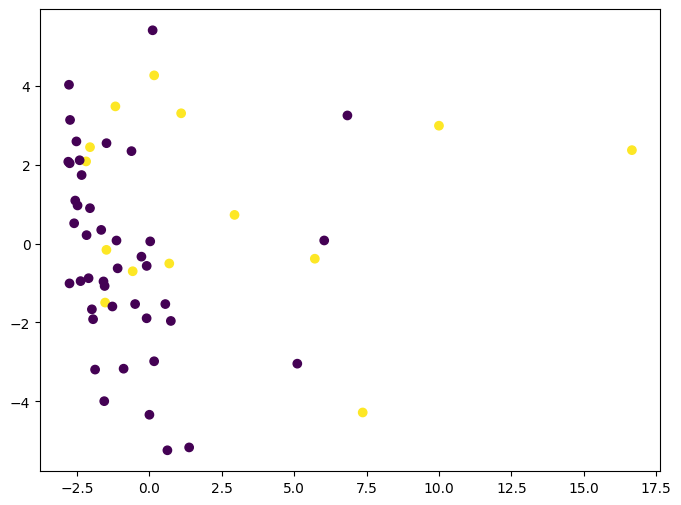

In [94]:
pca = PCA(n_components=25)
pca.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)

# Logistic Regression

In [95]:
scaler = StandardScaler().fit(X_train)
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
score = logistic_model.score(X_test,y_test)
print(score)

1.0


# SVM

In [96]:
from sklearn import datasets, svm
svm_model = svm.SVC()
svm_model.fit(X_train_pca, y_train)
score = svm_model.score(X_test_pca,y_test)
print(score)

1.0


# Neural Networks

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.3, random_state=4)
X_train, X_test, y_train, y_test = features[0:56], features[56:], y[0:56], y[56:]
# X_train, X_test, y_train, y_test = features[0:336], features[336:], y[0:336], y[336:]

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=15)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the feedforward neural network
neural_model = Sequential()
neural_model.add(Dense(64, activation='relu', input_shape=(15,)))
neural_model.add(Dense(64, activation='relu'))
neural_model.add(Dense(32, activation='relu'))
neural_model.add(Dense(100, activation = 'relu'))
neural_model.add(Dropout(0.5))
neural_model.add(Dense(3, activation='softmax'))
from tensorflow.keras.optimizers import Adam
# Compile the model
optimizer = Adam(learning_rate=0.001)
neural_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Train the model
# history = model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=45, batch_size=100, verbose=2)
val_accuracies = []
for i in range(1):
    # ... your code ...
    history = neural_model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=45, batch_size=100, verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    val_accuracies.append(val_accuracy)

avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print("Average Validation Accuracy:", avg_val_accuracy)


Average Validation Accuracy: 1.0


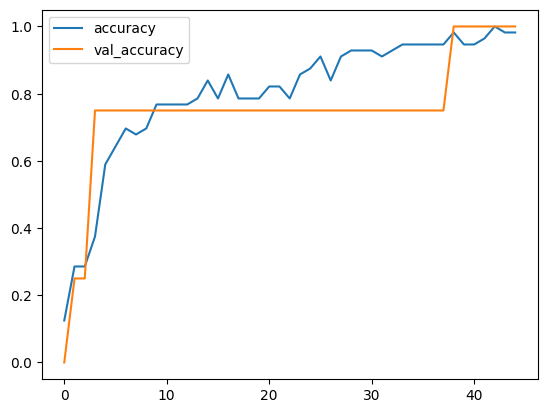

In [99]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [100]:
def model_predict(X_test, y_test, model):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis = 1)
    y_test1 = y_test.astype('int64')
    testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions - testYarg !=0)
    miss_class = miss_class[0]
    return predictions, miss_class

In [101]:
predictions, miss_class = model_predict(X_test_pca, y_test, neural_model)
print(miss_class)
print(predictions)

1/1 [==============================] - 0s 70ms/step
[]
[1 2 1 1]


# Random forest method

[2, 3, 7, 0, 9]


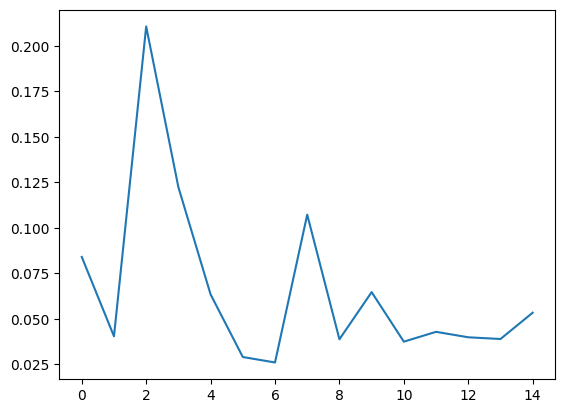

In [102]:
#from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# define the model
randomf_model = RandomForestClassifier()

# fit/train the model on all features
randomf_model.fit(X_train_pca, y_train)

#score
score=randomf_model.score(X_test_pca, y_test)

# get feature importance
importance = randomf_model.feature_importances_

#creat a dictionary with key=indices, and values=importance
important_features_dict = {}
for idx, val in enumerate(importance):
    important_features_dict[idx] = val
# sorting 
important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)
# print indices of top 5 features
print(important_features_list[:5])
plt.plot(importance)

# Cross-validation score of different models

In [103]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
def cross_validation(X, y, model):
    cv = KFold(n_splits= 5, random_state=1, shuffle=True)
    scores = cross_val_score(model, X,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return scores

In [104]:
cv_logistic = cross_validation(features, y, logistic_model)
print(cv_logistic)
# cv_neural = cross_validation(features, y, neural_model)
# print(cv_neural)
cv_randomf = cross_validation(features, y, randomf_model)
print(cv_randomf)

Accuracy: 0.667 (0.253)
[0.75       0.16666667 0.83333333 0.75       0.83333333]
Accuracy: 0.867 (0.113)
[0.83333333 1.         0.91666667 0.66666667 0.91666667]
